In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import pc_analysis as pca
from scipy import stats

#Load data
sw_data = pd.read_hdf('data/sw_outputs.h5', 'prime_predict_bs') #Load solar wind data from PRIME
sw_data = sw_data.drop_duplicates(subset='Epoch')

#Load magnetosheath data from PRIME
sh_data = pd.read_hdf('data/sheath_outputs_mp.h5', 'prime_predict_mp')
sh_data = sh_data.drop_duplicates(subset='Epoch')

pc_2015 = pd.read_csv('data/pcnpcs2015.txt', sep='\s+') #Load PCN and PCS data from 2015
pc_2016 = pd.read_csv('data/pcnpcs2016.txt', sep='\s+') #Load PCN and PCS data from 2016
pc_2017 = pd.read_csv('data/pcnpcs2017.txt', sep='\s+') #Load PCN and PCS data from 2017
pc_2018 = pd.read_csv('data/pcnpcs2018.txt', sep='\s+') #Load PCN and PCS data from 2018
pc_2019 = pd.read_csv('data/pcnpcs2019.txt', sep='\s+') #Load PCN and PCS data from 2019
pc_2020 = pd.read_csv('data/pcnpcs2020.txt', sep='\s+') #Load PCN and PCS data from 2020
pc_2021 = pd.read_csv('data/pcnpcs2021.txt', sep='\s+') #Load PCN and PCS data from 2021
pc_2022 = pd.read_csv('data/pcnpcs2022.txt', sep='\s+') #Load PCN and PCS data from 2022
pc_2023 = pd.read_csv('data/pcnpcs2023.txt', sep='\s+') #Load PCN and PCS data from 2023

#Combine all PCN and PCS data into one dataframe
pc_data = pd.concat([pc_2015, pc_2016, pc_2017, pc_2018, pc_2019, pc_2020, pc_2021, pc_2022, pc_2023], ignore_index=True)
pc_data = pc_data.drop_duplicates() #Remove duplicate rows
pc_data = pc_data.reset_index(drop=True) #Reset index
#Replace all PCN and PCS values of 999.0 with N aN
pc_data = pc_data.replace(999.0, np.nan)
pc_data['Epoch'] = pd.to_datetime(pc_data['#year-month-day']+' '+pc_data['h:m']+'+0000', format='%Y-%m-%d %H:%M%z') #Convert date and time to datetime format
pc_data = pc_data.drop(columns=['#year-month-day', 'h:m']) #Remove original date and time columns
pc_data = pc_data.drop_duplicates(subset='Epoch') #Remove duplicate rows

In [ ]:
#Calculate PCC (PC combined) from PCN (PC North) and PCS (PC South)
#PCC is the mean of non-negative values of PCN and PCS
pc_data['PCC'] = (np.where(pc_data['PCN']>0, pc_data['PCN'], 0)+np.where(pc_data['PCS']>0, pc_data['PCS'], 0))/2
#Set PCC to NaN if either PCN and PCS are NaN
pc_data['PCC'] = np.where(np.isnan(pc_data['PCN']) | np.isnan(pc_data['PCS']), np.nan, pc_data['PCC'])
#Timeshift the data to account for the time it takes for the solar wind to reach the magnetopause and map into the ionosphere
#Also, add the shifted data into pc_data
timeshift = pd.Timedelta(seconds=17*60) #Time shift
for key in sw_data.columns:
    if key == 'Epoch':
        continue
    #Interpolate the solar wind data to the PCN and PCS times
    pc_data[key] = np.interp(pc_data['Epoch'].astype('int'), (sw_data['Epoch']+timeshift).astype('int'), sw_data[key])
    #sw_data[key].interp(Epoch=pc_data.coords['Epoch']-timeshift)
#Drop pc_data Epochs with NaN values in any of the data variables
pc_data = pc_data.dropna(subset='Epoch')
#Take just the first 10000 data points
#pc_data = pc_data.isel(Epoch=slice(0, 1000))

In [22]:
#No regression recalibration binned means

#Caluclate Em from solar wind data
sw_data['Em'] = 0.001*np.sqrt(sw_data['Vi_xgse'].to_numpy()**2+sw_data['Vi_ygse'].to_numpy()**2+sw_data['Vi_zgse'].to_numpy()**2)*np.sqrt(sw_data['B_ygsm'].to_numpy()**2+sw_data['B_zgsm'].to_numpy()**2)*(np.sin(np.arctan2(sw_data['B_ygsm'].to_numpy(), sw_data['B_zgsm'].to_numpy())/2))**2

#Calculate Erx from magnetosheath data
sh_data['B'] = np.sqrt(sh_data['B_xgsm'].to_numpy()**2+sh_data['B_ygsm'].to_numpy()**2+sh_data['B_zgsm'].to_numpy()**2)
sh_data['beta'] = 0.403*sh_data['Ni'].to_numpy()*sh_data['Tiperp'].to_numpy()/(sh_data['B'].to_numpy()**2)
sh_data['Erx'] = 0.02 * 0.2 * (sh_data['B'].to_numpy()**2) * (((1+sh_data['beta'].to_numpy())/sh_data['Ni'].to_numpy())**(1/2)) * (np.sin(np.arctan2(sh_data['B_ygsm'].to_numpy(), sh_data['B_zgsm'].to_numpy())/2))**2

#Add shifted E_SW data to pc_data
timeshift = pd.Timedelta(seconds=17*60) #Time shift
pc_data['Em'] = np.interp(pc_data['Epoch'].astype('int'), (sw_data['Epoch']+timeshift).astype('int'), sw_data['Em'])
#Add shifted Erx data to pc_data
timeshift = pd.Timedelta(seconds=17*60) #Time shift
pc_data['Erx'] = np.interp(pc_data['Epoch'].astype('int'), (sh_data['Epoch']+timeshift).astype('int'), sh_data['Erx'])
#Drop pc_data Epochs with NaN values in any of the data variables
pc_data = pc_data.dropna()
#There are some gaps from the interpolation. Cut data from 2015-01-01 00:00:00 to 2015-03-13 05:12:00 and 2023-01-31 00:16:00 to 2024-01-01 00:00:00
pc_data = pc_data[(pc_data['Epoch']<'2015-01-01 00:00:00') | (pc_data['Epoch']>'2015-03-13 05:12:00')]
pc_data = pc_data[(pc_data['Epoch']<'2023-01-31 00:16:00') | (pc_data['Epoch']>'2024-01-01 00:00:00')]
#pc_data = pc_data[(pc_data['Em']!=0.3699549371964591)&(pc_data['Em']!=6.219327537178763)&(pc_data['Erx']!=0.5311095456386149)&(pc_data['Erx']!=0.5820450295447854)] #This was the original condition to remove the gaps (yuck!)

/tmp/ipykernel_308/3031210788.py:9: RuntimeWarning: invalid value encountered in sqrt
  sh_data['Erx'] = 0.02 * 0.2 * (sh_data['B'].to_numpy()**2) * (((1+sh_data['beta'].to_numpy())/sh_data['Ni'].to_numpy())**(1/2)) * (np.sin(np.arctan2(sh_data['B_ygsm'].to_numpy(), sh_data['B_zgsm'].to_numpy())/2))**2


/tmp/ipykernel_308/1160048351.py:5: UserWarning: Log scale: values of z <= 0 have been masked
  cs = plt.contour(np.arange(0,lim,0.1)[:-1], np.arange(0,lim,0.1)[:-1], hist, norm=LogNorm(), cmap = 'inferno')


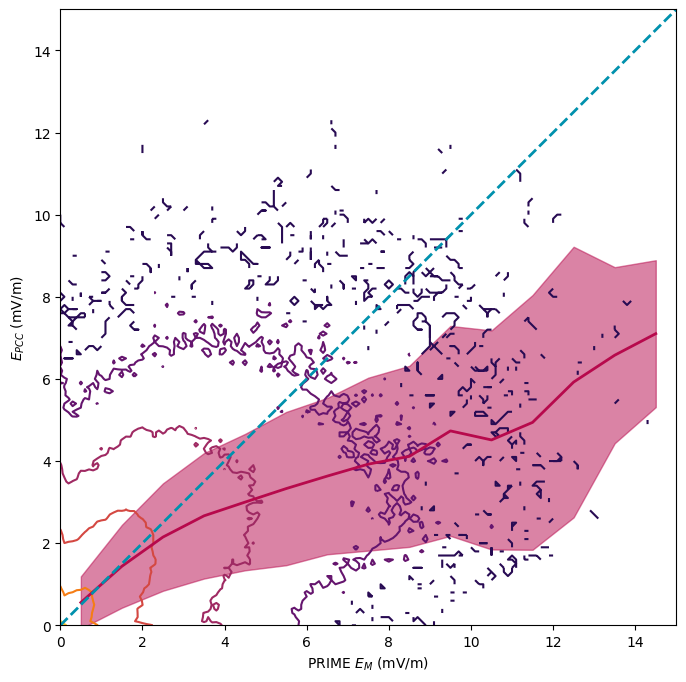

In [24]:
#Bin the PCC to evaluate the relationship between PCC and Em
lim = 15 #Maximum Em value to include in the plot
binsize = 1
bins = np.arange(0, lim+binsize, binsize)
#Bin the PCC according to Em and average and get std of PCC in each bin
PCC_binned, _ = np.histogram(pc_data['Em'], bins=bins, weights=pc_data['PCC'])
PCC_binned = PCC_binned/np.histogram(pc_data['Em'], bins=bins)[0]
PCC_err, _ = np.histogram(pc_data['Em'], bins=bins, weights=pc_data['PCC']**2)
PCC_err = np.sqrt(PCC_err/np.histogram(pc_data['Em'], bins=bins)[0]-PCC_binned**2)
#Calculate the number of samples in each bin
counts, _ = np.histogram(pc_data['Em'], bins=bins)

fig, ax = plt.subplots(figsize=(8,8))
#Plot PCC vs Em in contours when they are not nan
mask = np.isnan(pc_data['Em']) | np.isnan(pc_data['PCC'])
hist, _, _ = np.histogram2d(pc_data['PCC'][~mask], pc_data['Em'][~mask], bins=np.arange(0,lim,binsize))
cs = plt.contour(np.arange(0,lim,binsize)[:-1], np.arange(0,lim,binsize)[:-1], hist, norm=LogNorm(), cmap = 'inferno')
plt.plot(bins[:-1]+binsize/2, PCC_binned, color='#B7094C', linestyle='-', linewidth=2) #Plot mean PCC vs Em in each bin
plt.fill_between(bins[:-1]+binsize/2, PCC_binned+PCC_err, PCC_binned-PCC_err, color='#B7094C', alpha=0.5) #Fill between mean PCC+1sigma and mean PCC-1sigma
plt.plot([0, lim], [0, lim], color='#0091AD', linestyle='--', linewidth=2) #Plot y=x line
plt.xlim(0,lim)
plt.ylim(0,lim)
plt.xlabel('PRIME $E_{M}$ (mV/m)')
plt.ylabel('$E_{PCC}$ (mV/m)')
plt.gca().set_aspect('equal', adjustable='box')
#plt.savefig('plots/prime_saturation.png', dpi = 300)

/tmp/ipykernel_308/2268364620.py:4: UserWarning: Log scale: values of z <= 0 have been masked
  cs = plt.contour(np.arange(0,lim*4,binsize)[:-1], np.arange(0,lim*4,binsize)[:-1], hist, norm=LogNorm(), cmap = 'inferno')


Text(0, 0.5, '$E_{PCC}$ (mV/m)')

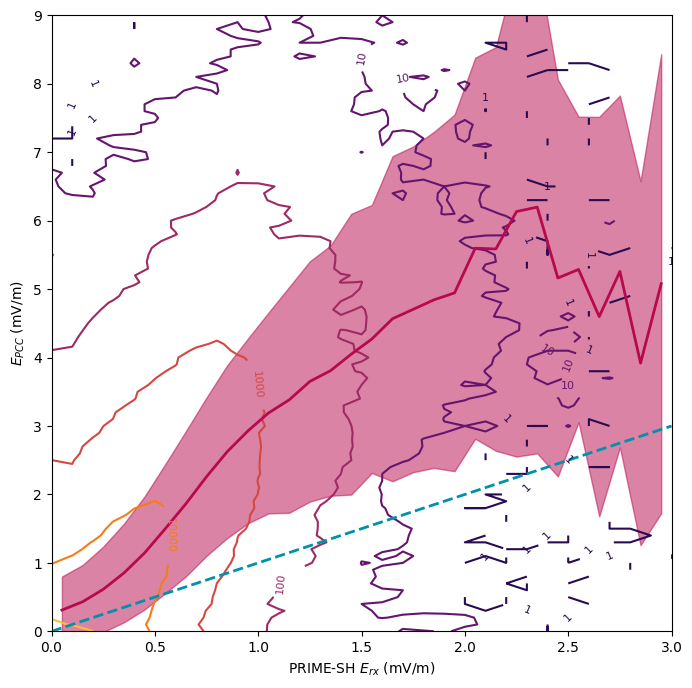

In [44]:
#Bin the PCC to evaluate the relationship between PCC and Erx
lim = 3 #Maximum Erx value to include in the plot
binsize = 0.1
bins = np.arange(0, lim+binsize, binsize)
#Bin the PCC according to Erx and average and get std of PCC in each bin
PCC_binned, _ = np.histogram(pc_data['Erx'], bins=bins, weights=pc_data['PCC'])
PCC_binned = PCC_binned/np.histogram(pc_data['Erx'], bins=bins)[0]
PCC_err, _ = np.histogram(pc_data['Erx'], bins=bins, weights=pc_data['PCC']**2)
PCC_err = np.sqrt(PCC_err/np.histogram(pc_data['Erx'], bins=bins)[0]-PCC_binned**2)
#Calculate the number of samples in each bin
counts, _ = np.histogram(pc_data['Erx'], bins=bins)

fig, ax = plt.subplots(figsize=(8,8))
mask = np.isnan(pc_data['Erx']) | np.isnan(pc_data['PCC'])
hist, _, _ = np.histogram2d(pc_data['PCC'][~mask], pc_data['Erx'][~mask], bins=np.arange(0,lim*4,binsize))
cs = plt.contour(np.arange(0,lim*4,binsize)[:-1], np.arange(0,lim*4,binsize)[:-1], hist, norm=LogNorm(), cmap = 'inferno')
plt.clabel(cs, inline=True, fontsize=8)
plt.plot(bins[:-1]+binsize/2, PCC_binned, color='#B7094C', linestyle='-', linewidth=2) #Plot mean PCC vs Erx in each bin
plt.fill_between(bins[:-1]+binsize/2, PCC_binned+PCC_err, PCC_binned-PCC_err, color='#B7094C', alpha=0.5) #Fill between mean PCC+1sigma and mean PCC-1sigma
plt.plot([0, lim], [0, lim], color='#0091AD', linestyle='--', linewidth=2) #Plot y=x line
plt.xlim(0,lim)
plt.ylim(0,9)
plt.xlabel('PRIME-SH $E_{rx}$ (mV/m)')
plt.ylabel('$E_{PCC}$ (mV/m)')
#plt.gca().set_aspect('equal', adjustable='box')
#plt.savefig('plots/primesh_saturation.png', dpi = 300)

/tmp/ipykernel_308/1541372183.py:15: UserWarning: Log scale: values of z <= 0 have been masked
  cs = plt.contour(np.arange(0,lim,binsize)[:-1], np.arange(0,lim,binsize)[:-1], hist, norm=LogNorm(), levels=10, cmap = 'inferno')


Text(0, 0.5, 'PRIME-SH $E_{RX}$ (mV/m)')

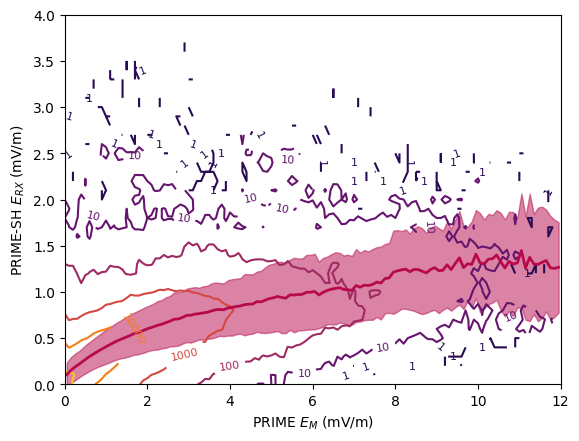

In [49]:
#Bin the Erx to evaluate the relationship between Erx and Em
lim = 12 #Maximum Erx value to include in the plot
binsize = 0.1
bins = np.arange(0, lim+binsize, binsize)
#Bin the Erx according to Em and average and get std of Erx in each bin
Erx_binned, _ = np.histogram(pc_data['Em'], bins=bins, weights=pc_data['Erx'])
Erx_binned = Erx_binned/np.histogram(pc_data['Em'], bins=bins)[0]
Erx_err, _ = np.histogram(pc_data['Em'], bins=bins, weights=pc_data['Erx']**2)
Erx_err = np.sqrt(Erx_err/np.histogram(pc_data['Em'], bins=bins)[0]-Erx_binned**2)
#Calculate the number of samples in each bin
counts, _ = np.histogram(pc_data['Em'], bins=bins)

mask = np.isnan(pc_data['Em']) | np.isnan(pc_data['Erx'])
hist, _, _ = np.histogram2d(pc_data['Erx'][~mask], pc_data['Em'][~mask], bins=np.arange(0,lim,binsize))
cs = plt.contour(np.arange(0,lim,binsize)[:-1], np.arange(0,lim,binsize)[:-1], hist, norm=LogNorm(), levels=10, cmap = 'inferno')
plt.plot(bins[:-1]+binsize/2, Erx_binned, color='#B7094C', linestyle='-', linewidth=2) #Plot mean Erx vs Em in each bin
plt.fill_between(bins[:-1]+binsize/2, Erx_binned+Erx_err, Erx_binned-Erx_err, color='#B7094C', alpha=0.5) #Fill between mean Erx+1sigma and mean Erx-1sigma
#plt.plot([0, lim], [0, lim], color='#0091AD', linestyle='--', linewidth=2) #Plot y=x line
plt.clabel(cs, inline=True, fontsize=8)
plt.xlim(0,lim)
plt.ylim(0,4)
plt.xlabel('PRIME $E_{M}$ (mV/m)')
plt.ylabel('PRIME-SH $E_{RX}$ (mV/m)')
#plt.gca().set_aspect('equal', adjustable='box')


In [ ]:
#At each timestep, generate n samples of each parameter according to the uncertainty in the parameter
#Then, calculate the motional electric field in the solar wind for each sample and store the results
n = 1000
Em = np.array([])
PCC = np.array([])
for i in np.arange(len(pc_data.coords['Epoch'])):
    #Generate n samples of each parameter
    samples = pca.generate_samples(pc_data.isel(Epoch=i), n)
    #Calculate the motional electric field in the solar wind for each sample
    Em_stage = 0.001*np.sqrt(samples['Vi_xgse'].to_numpy()**2+samples['Vi_ygse'].to_numpy()**2+samples['Vi_zgse'].to_numpy()**2)*np.sqrt(samples['B_ygsm'].to_numpy()**2+samples['B_zgsm'].to_numpy()**2)*(np.sin(np.arctan2(samples['B_ygsm'].to_numpy(), samples['B_zgsm'].to_numpy())/2))**2
    #Repeat the PCC values for each sample
    PCC_stage = np.repeat(pc_data.isel(Epoch=i)['PCC'].to_numpy(), n)
    #Append the results to the arrays
    Em = np.append(Em, Em_stage)
    PCC = np.append(PCC, PCC_stage)
    print(i+1, 'of', len(pc_data.coords['Epoch']), end='\r')
    
#Bin the PCC to evaluate the relationship between PCC and Em
lim = 20 #Maximum Em value to include in the plot
binsize = 1
bins = np.arange(0, lim+binsize, binsize)
#Bin the PCC according to Em and average and get std of PCC in each bin
PCC_binned, _ = np.histogram(Em, bins=bins, weights=PCC)
PCC_binned = PCC_binned/np.histogram(Em, bins=bins)[0]
PCC_err, _ = np.histogram(Em, bins=bins, weights=PCC**2)
PCC_err = np.sqrt(PCC_err/np.histogram(Em, bins=bins)[0]-PCC_binned**2)
#Calculate the number of samples in each bin
counts, _ = np.histogram(Em, bins=bins)


#Plot the results
fig, ax = plt.subplots(figsize=(8,8))
plt.plot(Em, PCC, 'k.', markersize=1) #Plot PCC vs Em
plt.plot(bins[:-1]+0.5, PCC_binned, color='#B7094C', linestyle='-', linewidth=2) #Plot mean PCC vs Em in each bin
plt.fill_between(bins[:-1]+0.5, PCC_binned+PCC_err, PCC_binned-PCC_err, color='#B7094C', alpha=0.5) #Fill between mean PCC+1sigma and mean PCC-1sigma
plt.plot([0, lim], [0, lim], color='#0091AD', linestyle='--', linewidth=2) #Plot y=x line
plt.xlim(0,lim)
plt.ylim(0,lim)
plt.xlabel('PRIME $E_{M}$ (mV/m)')
plt.ylabel('$E_{PCC}$ (mV/m)')
plt.gca().set_aspect('equal', adjustable='box')
#plt.savefig('plots/prime_saturation_test.png', dpi = 300)
plt.show()
